# MACD Cross Strategy

In [1]:
import sys
from pathlib import Path

import matplotlib
if not hasattr(matplotlib.rcParams, '_get'):
    matplotlib.rcParams._get = matplotlib.rcParams.get

import matplotlib.pyplot as plt
import pandas as pd

project_root = Path('..').resolve()
src_path = project_root / 'src'
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

from data_loader import load_ohlcv_csv
from backtest import run_backtest
from qflib_metrics import qflib_metrics_from_returns
from strategy_macd import macd_components, macd_signals


In [2]:
df = load_ohlcv_csv('../data/OKX_BTCUSDT, 1D.csv')
df.head()


,open,high,low,close,EMA,Oversold HWO Up,Overbought HWO Down,HWO Up,HWO Down,ATR,MACD,Signal
time,,,,,,,,,,,,
2025-01-17 00:00:00+00:00,99990.9,105847.4,99950.1,104084.4,87477.819959,NaN,NaN,NaN,NaN,3858.413818,806.234733,45.098916
2025-01-18 00:00:00+00:00,104084.5,104984.0,102288.0,104551.6,87780.010756,NaN,NaN,NaN,NaN,3775.384260,1263.568044,288.792741
2025-01-19 00:00:00+00:00,104551.6,106448.6,99639.4,101334.0,88019.904371,NaN,NaN,NaN,NaN,3992.085384,1350.803339,501.194861
2025-01-20 00:00:00+00:00,101334.0,109800.0,99526.4,102264.3,88272.017568,NaN,NaN,NaN,78.924812,4440.765000,1477.968275,696.549544
2025-01-21 00:00:00+00:00,102263.9,107285.8,100111.0,106150.1,88588.443806,NaN,NaN,NaN,NaN,4636.053214,1870.734327,931.386500


In [3]:
macd_df = macd_components(df['close'])
df = df.join(macd_df)
df[['close', 'macd', 'macd_signal']].tail()


,close,macd,macd_signal
time,,,
2025-11-08 00:00:00+00:00,102320.1,-2717.306765,-2006.570810
2025-11-09 00:00:00+00:00,104722.4,-2601.539761,-2125.564600
2025-11-10 00:00:00+00:00,106012.0,-2378.317866,-2176.115253
2025-11-11 00:00:00+00:00,103061.7,-2411.677146,-2223.227632
2025-11-12 00:00:00+00:00,103274.7,-2393.338382,-2257.249782


In [4]:
positions = macd_signals(df)
positions.value_counts()


position
0.0    151
1.0    149
Name: count, dtype: int64

In [5]:
bt = run_backtest(df.copy(), positions)
bt[['strategy_ret', 'equity_curve']].tail()


,strategy_ret,equity_curve
time,,
2025-11-08 00:00:00+00:00,-0.0,8124.208532
2025-11-09 00:00:00+00:00,0.0,8124.208532
2025-11-10 00:00:00+00:00,0.0,8124.208532
2025-11-11 00:00:00+00:00,-0.0,8124.208532
2025-11-12 00:00:00+00:00,0.0,8124.208532


In [6]:
metrics = qflib_metrics_from_returns(bt['strategy_ret'])
metrics_df = pd.DataFrame([metrics], index=['MACD'])
metrics_df


,total_return,cagr,sharpe_ratio,annualised_vol,max_drawdown,avg_drawdown_duration
MACD,-0.187579,-0.160122,-0.671701,0.222596,-0.27186,298.0


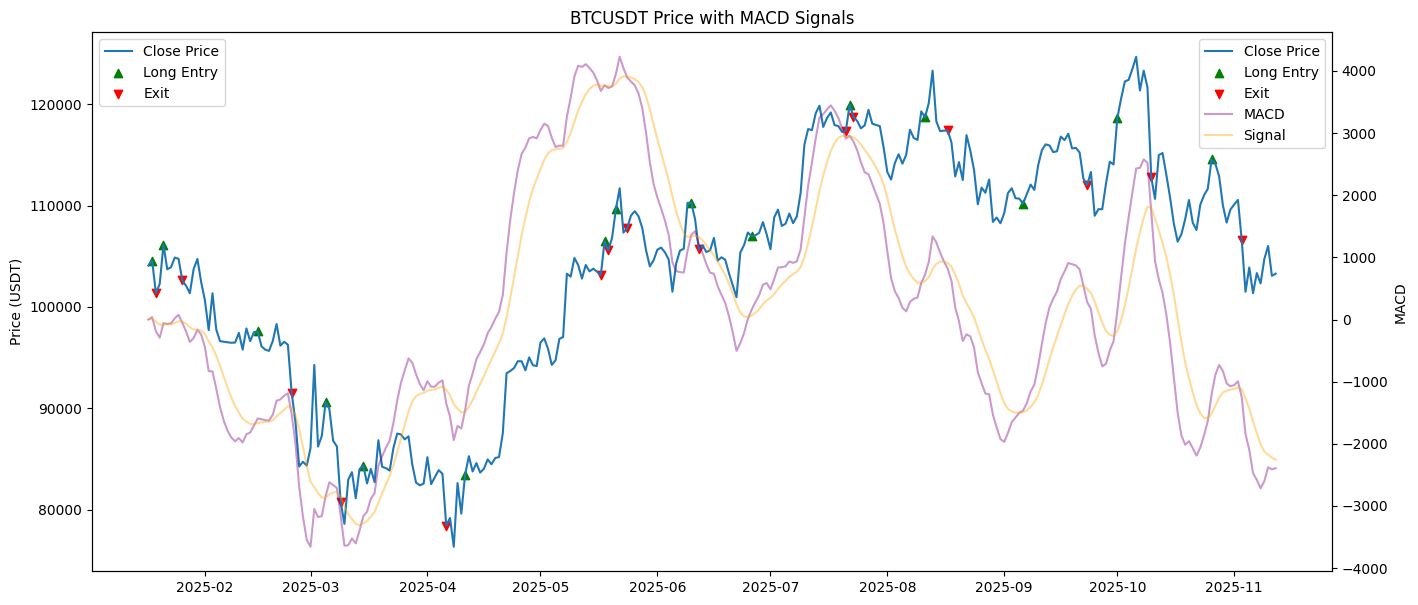

In [7]:
fig, ax = plt.subplots(figsize=(16, 7))
ax.plot(df.index, df['close'], label='Close Price')
entries = positions.diff().fillna(0) > 0
exits = positions.diff().fillna(0) < 0
ax.scatter(df.index[entries], df.loc[entries, 'close'], marker='^', color='green', label='Long Entry')
ax.scatter(df.index[exits], df.loc[exits, 'close'], marker='v', color='red', label='Exit')
ax.set_title('BTCUSDT Price with MACD Signals')
ax.set_ylabel('Price (USDT)')
ax.legend(loc='upper left')
ax2 = ax.twinx()
ax2.plot(df.index, df['macd'], color='purple', alpha=0.4, label='MACD')
ax2.plot(df.index, df['macd_signal'], color='orange', alpha=0.4, label='Signal')
ax2.set_ylabel('MACD')
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')
plt.show()


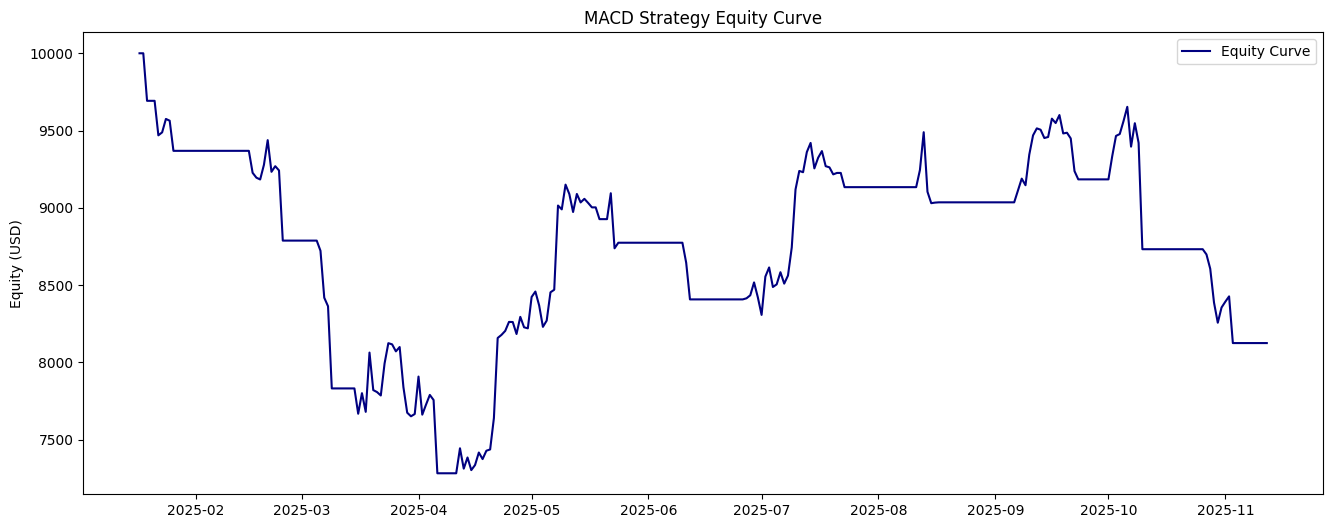

In [8]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(bt.index, bt['equity_curve'], label='Equity Curve', color='navy')
ax.set_title('MACD Strategy Equity Curve')
ax.set_ylabel('Equity (USD)')
ax.legend()
plt.show()
